<a href="https://colab.research.google.com/github/dustiny5/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/module3-model-interpretation/LS_DS_243_Model_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Practicing & Understanding Predictive Modeling_

# Model Interpretation

### Links
- [Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability)
  - [Permutation Importance](https://www.kaggle.com/dansbecker/permutation-importance)
  - [Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
  - [Shapley Values](https://www.kaggle.com/dansbecker/shap-values)
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)
  - [(Permutation) Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html)
  - [Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
  - [Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- Random Forest Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

### Libraries
- [eli5](https://github.com/TeamHG-Memex/eli5): `conda install -c conda-forge eli5` / `pip install eli5`
- [PDPbox](https://github.com/SauceCat/PDPbox): `pip install pdpbox`
- [shap](https://github.com/slundberg/shap): `conda install -c conda-forge shap` / `pip install shap`

### Library quirks to work around

1. Some of these libraries don't work with pipelines.

2. eli5 PermutationImportance + xgboost + pandas doesn't work, but [there's a work-around:](https://www.kaggle.com/dansbecker/permutation-importance#392299)

> Important note here for anyone trying to use eli5's PermutationImportance on XGBoost estimators, currently you need to train your models using ".values or .as_matrix()" with you input data (X and Y), otherwise PermutationImportance won't work, [source](https://github.com/TeamHG-Memex/eli5/issues/256).

3. PDPbox _only_ works with pandas.

***[Data science is often about putting square pegs in round holes!](https://www.youtube.com/watch?v=ry55--J4_VQ)***

### 3 types of model explanations today!

#### Global explanation: all features in relation to each other
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### Global explanation: individual feature(s) in relation to target
- Partial Dependence plots

#### Individual prediction explanation
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

### Lecture dataset: Lending Club

#### Can you predict if peer-to-peer loans are charged off or fully paid?

[Lending Club says,](https://www.lendingclub.com/) _"Our mission is to transform the banking system to make credit more affordable and investing more rewarding."_ You can view their [loan statistics and visualizations](https://www.lendingclub.com/info/demand-and-credit-profile.action).

[According to Wikipedia,](https://en.wikipedia.org/wiki/Lending_Club)

> Lending Club is the world's largest peer-to-peer lending platform. Lending Club enables borrowers to create unsecured personal loans between $1,000 and 40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

The data is a stratified sample of 100,000 Lending Club peer-to-peer loans with a loan status of "Charged Off" or "Fully Paid", issued from 2007 through 2018.

The set of variables included here are the intersection of what's available both when investors download historical data and when investors browse loans for manual investing.

Data dictionary: https://resources.lendingclub.com/LCDataDictionary.xlsx

Target: `charged_off`

**This is a classification problem, so we'll choose a [scoring metric](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) for classification: ROC AUC.**

**For our evaluation protocol, we'll choose cross-validation with independent test set.**

In [0]:
!pip install eli5
!pip install pdpbox
!pip install shap
!pip install category_encoders

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500


url = 'https://drive.google.com/uc?export=download&id=1AafT_i1dmfaxqKiyFofVndleKozbQw3l'
df = pd.read_csv(url)

X = df.drop(columns='charged_off')
y = df['charged_off']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, test_size=0.20, stratify=y, random_state=42)


def wrangle(X):
    X = X.copy()
    
    # Drop some columns
    X = X.drop(columns='id')  # id is random
    X = X.drop(columns=['member_id', 'url', 'desc'])  # All null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    
    # Transform sub_grade from "A1" - "G5" to 1.1 - 7.5
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    # Transform earliest_cr_line to an integer: how many days it's been open
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = pd.Timestamp.today() - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days
    
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    # Drop categoricals with high cardinality
    X = X.drop(columns=['emp_title', 'zip_code'])
    
    # Transform features with many nulls to binary flags
    many_nulls = ['sec_app_mths_since_last_major_derog',
                  'sec_app_revol_util',
                  'sec_app_earliest_cr_line',
                  'sec_app_mort_acc',
                  'dti_joint',
                  'sec_app_collections_12_mths_ex_med',
                  'sec_app_chargeoff_within_12_mths',
                  'sec_app_num_rev_accts',
                  'sec_app_open_act_il',
                  'sec_app_open_acc',
                  'revol_bal_joint',
                  'annual_inc_joint',
                  'sec_app_inq_last_6mths',
                  'mths_since_last_record',
                  'mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog',
                  'mths_since_recent_revol_delinq',
                  'mths_since_last_delinq',
                  'il_util',
                  'emp_length',
                  'mths_since_recent_inq',
                  'mo_sin_old_il_acct',
                  'mths_since_rcnt_il',
                  'num_tl_120dpd_2m',
                  'bc_util',
                  'percent_bc_gt_75',
                  'bc_open_to_buy',
                  'mths_since_recent_bc']

    for col in many_nulls:
        X[col] = X[col].isnull()
    
    # For features with few nulls, do mean imputation
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # Return the wrangled dataframe
    return X


# Wrangle train and test in the same way
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

In [18]:
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=2, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   38.5s remaining:   38.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   49.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   49.5s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f07577e5e48>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f07577e5e10>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [25]:
print('Cross-Validation ROC AUC:', search.best_score_)

Cross-Validation ROC AUC: 0.7214766256277261


In [26]:
from sklearn.metrics import roc_auc_score
best = search.best_estimator_
X_test = encoder.transform(X_test)
y_pred_proba = best.predict_proba(X_test.values)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.7066817557945004


# 1a. Feature Importances
- Global explanation: all features in relation to each other
- Default, fastest, good for first estimates

[Here's some food for thought](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/) about feature importances:

>**When the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others.** But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

For more information, see [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html).

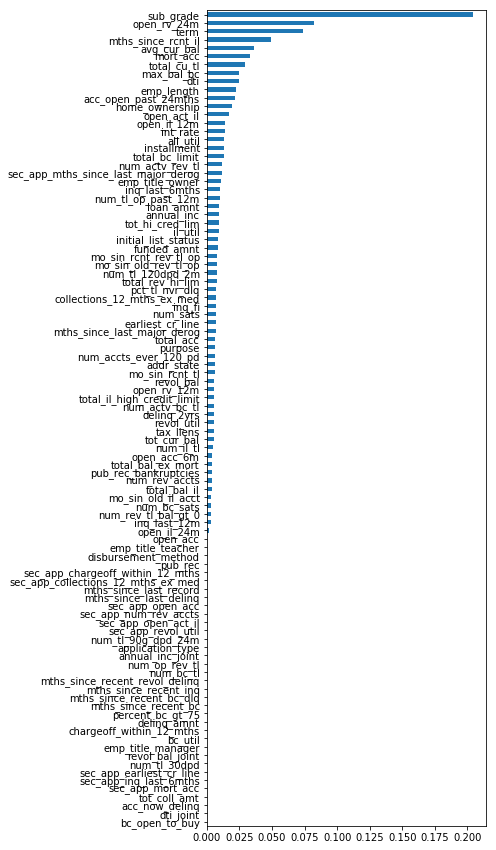

In [27]:
# TODO

n = len(X_train.columns)
figsize = (5,15)

importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]
plt.figure(figsize=figsize)
top_n.plot.barh();

# 1b. Drop-Column Importance
- Global explanation: all features in relation to each other
- The best in theory, but much too slow in practice

`sub_grade` is correlated with `int_rate`. If we drop `sub_grade`, the model uses other correlated features more, so the score remains similar.

In [28]:
from sklearn.model_selection import cross_val_score

X_train_no_subgrade = X_train.drop(columns='sub_grade')
new_model = XGBClassifier(max_depth=2, n_estimators=200, n_jobs=-1, random_state=42)

score_with = cross_val_score(new_model, X_train, y_train, cv=2, scoring='roc_auc').mean()
print('Cross-Validation ROC AUC with sub_grade:', score_with)

score_without = cross_val_score(new_model, X_train_no_subgrade, y_train, cv=2, scoring='roc_auc').mean()
print('Cross-Validation ROC AUC without sub_grade:', score_without)

print('Drop-Column Importance:', score_with - score_without)

Cross-Validation ROC AUC with sub_grade: 0.7210805152839438
Cross-Validation ROC AUC without sub_grade: 0.7192418242281939
Drop-Column Importance: 0.0018386910557498526


# 1c. Permutation Importance
- Global explanation: all features in relation to each other
- A good compromise!

Permutation Importance is a compromise between Feature Importance based on impurity reduction (which is the fastest) and Drop Column Importance (which is the "best.")

[The ELI5 library documentation explains,](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)

> Importance can be measured by looking at how much the score (accuracy, F1, R^2, etc. - any score we’re interested in) decreases when a feature is not available.
>
> To do that one can remove feature from the dataset, re-train the estimator and check the score. But it requires re-training an estimator for each feature, which can be computationally intensive. ...
>
>To avoid re-training the estimator we can remove a feature only from the test part of the dataset, and compute score without using this feature. It doesn’t work as-is, because estimators expect feature to be present. So instead of removing a feature we can replace it with random noise - feature column is still there, but it no longer contains useful information. This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail). The simplest way to get such noise is to shuffle values for a feature, i.e. use other examples’ feature values - this is how permutation importance is computed.
>
>The method is most suitable for computing feature importances when a number of columns (features) is not huge; it can be resource-intensive otherwise.

### Do-It-Yourself way, for intuition

In [30]:
# TODO

X_test['sub_grade'].head()

5055     2.3
86027    2.2
86874    4.4
59692    4.2
47200    2.4
Name: sub_grade, dtype: float64

In [32]:
X_test_permuted = X_test.copy()

# Permutation/shuffing values of sub_grade an important feature
X_test_permuted['sub_grade'] = np.random.permutation(X_test_permuted['sub_grade'])
X_test_permuted['sub_grade'].head()

5055     2.1
86027    4.1
86874    1.4
59692    2.4
47200    3.4
Name: sub_grade, dtype: float64

In [35]:
print('Test ROC AUC score with sub_grade:', roc_auc_score(y_test, y_pred_proba))

# Predict with X_test_permuted
y_pred_proba = best.predict_proba(X_test_permuted.values)[:,-1]

# Big change in roc auc score with shuffled sub_grade
print('Test ROC AUC score with permuted sub_grade:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC score with sub_grade: 0.5739545011944311
Test ROC AUC score with permuted sub_grade: 0.5739545011944311


In [37]:
# Try permutation with an unimportant feature
feature = 'initial_list_status'
X_test_permuted = X_test.copy()

X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature])

# Predict with original values
y_pred_proba = best.predict_proba(X_test.values)[:,-1]
print('Test ROC AUC score with',feature, roc_auc_score(y_test, y_pred_proba))

# Predict with X_test_permuted
y_pred_proba = best.predict_proba(X_test_permuted.values)[:,-1]
# Big change in roc auc score with shuffled sub_grade
print('Test ROC AUC score with', feature, roc_auc_score(y_test, y_pred_proba))

# Little change in roc and auc score which suggest it to be unimportant


Test ROC AUC score with initial_list_status 0.7066817557945004
Test ROC AUC score with initial_list_status 0.7066817557945004


### With eli5 library

For more documentation on using this library, see:
- [eli5.sklearn.PermutationImportance](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)
- [eli5.show_weights](https://eli5.readthedocs.io/en/latest/autodocs/eli5.html#eli5.show_weights)

In [38]:
# TODO
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='roc_auc', cv='prefit', n_iter=2, random_state=42)
# n_iter - test random shuffle n amount of times

# Fit to numpy array of X_test panda series
permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=229,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
           n_iter=2, random_state=42, refit=True, scoring='roc_auc')

In [39]:
# List of panda's column name
feature_names = X_test.columns.tolist()

eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1252 ± 0.0012,sub_grade
0.0071 ± 0.0002,dti
0.0040 ± 0.0000,installment
0.0037 ± 0.0009,acc_open_past_24mths
0.0027 ± 0.0002,loan_amnt
0.0021 ± 0.0003,emp_title_owner
0.0019 ± 0.0010,emp_length
0.0018 ± 0.0008,mort_acc
0.0017 ± 0.0009,num_actv_rev_tl
0.0013 ± 0.0004,total_bc_limit


### We can use importances for feature selection

For example, we can remove features with zero importance. The model trains faster and the score does not decrease.

In [40]:
# TODO
print('Shape before removing features:', X_train.shape)

Shape before removing features: (80000, 98)


In [44]:
# Returns true or false of feature importances greater than 0
mask = permuter.feature_importances_ > 0

# Returns columns of True
features = X_train.columns[mask]

X_train = X_train[features]
print('Shape after removing features:', X_train.shape)

Shape after removing features: (80000, 44)


In [45]:
# Refit the model after we remove features with zero importance

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 4)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=2, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=2, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   20.6s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   26.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   26.4s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=2, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f07579647b8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f0757964898>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [46]:
print('Cross-Validation ROC AUC:', search.best_score_)

Cross-Validation ROC AUC: 0.7176825855707981


In [47]:
best = search.best_estimator_
X_test = X_test[features]
y_pred_proba = best.predict_proba(X_test)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.7122847022328442


# 2. Partial Dependence Plots

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdpbox.pdp.pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html)
- [API Reference: pdpbox.pdp.pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f0757296ef0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f07574a7be0>})

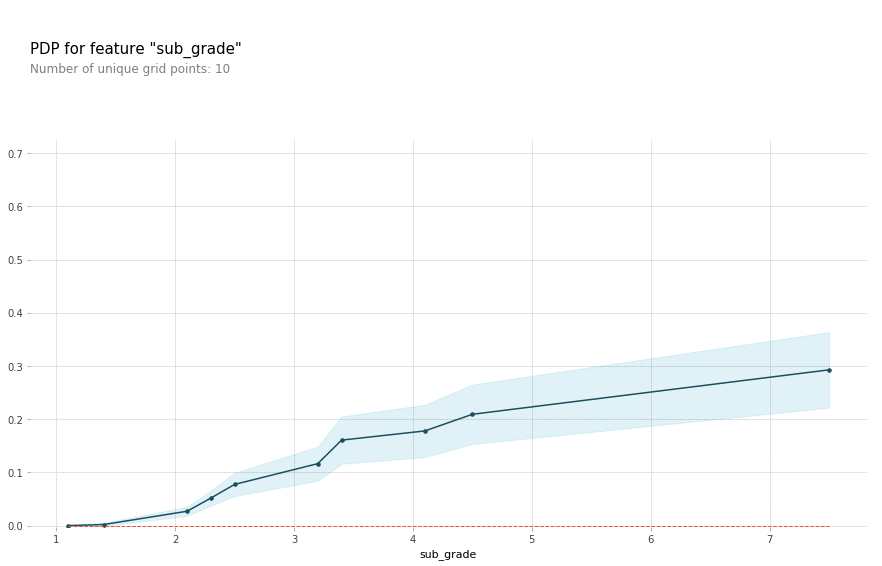

In [49]:
# TODO
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'sub_grade'

isolated = pdp_isolate(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)

# Plot shows as sub_grade(feature) increases the charge_off(target) increases, non-linearly
pdp_plot(isolated, feature_name=feature)

# For each observations/rows: all feature of the same, but the sub_grade changes.
## We plot each predictiong as we change the sub_grade while keeping all other features the same
### All Individual Conditional Expectation(ICE) curve is averaged from all observations by changing sub_grade
#### After, ICE averaged we get the PDP plot

### Explaining Partial Dependence Plots

From [PDPbox documentation](https://pdpbox.readthedocs.io/en/latest/):


>**The common headache**: When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

[Animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/)

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)

### Partial Dependence Plots with 2 features, to see interactions

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdpbox.pdp.pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html)
- [API Reference: pdpbox.pdp.pdp_interact_plot](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html)

Be aware of a bug in PDPBox version <= 0.20:
- With the `pdp_interact_plot` function, `plot_type='contour` gets an error, but `plot_type='grid'` works
- This will be fixed in the next release of PDPbox: https://github.com/SauceCat/PDPbox/issues/40

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f07571a96a0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f075717d358>})

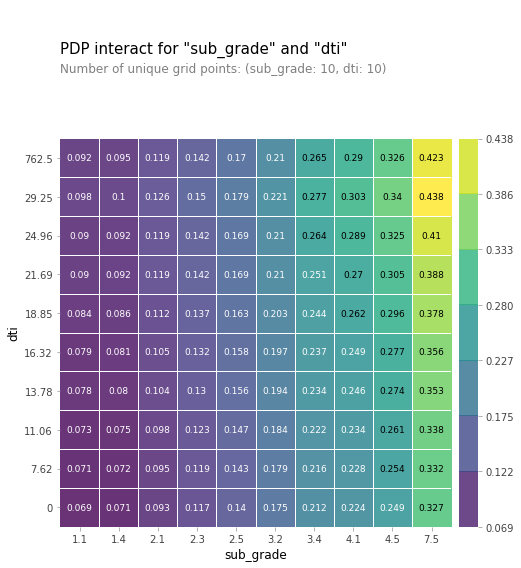

In [51]:
# TODO

from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['sub_grade', 'dti']

interaction = pdp_interact(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

# 3. Shapley Values to explain individual predictions

[Dan Becker explains,](https://www.kaggle.com/dansbecker/shap-values)

>You've seen (and used) techniques to extract general insights from a machine learning model. But what if you want to break down how the model works for an individual prediction?

>SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. 

>There is some complexity to the technique ... We won't go into that detail here, since it isn't critical for using the technique. [This blog post](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) has a longer theoretical explanation.

In [54]:
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)
confidence = np.abs(y_pred_proba - threshold)
preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 
                      'y_pred_proba': y_pred_proba, 
                      'confidence': confidence})

preds.head(10)

,y_test,y_pred,y_pred_proba,confidence
5055,0,0,0.144975,0.355025
86027,1,0,0.108940,0.391060
86874,0,0,0.405231,0.094769
59692,0,0,0.237333,0.262667
47200,0,0,0.163494,0.336506
23370,0,0,0.256175,0.243825
96894,1,0,0.215035,0.284965
4937,0,0,0.101468,0.398532
8753,0,0,0.213590,0.286410
83293,0,0,0.448247,0.051753


### True positive

In [61]:
# TODO
tp = preds[(y_pred==1) & (y_test==1)]
tp.sample()

,y_test,y_pred,y_pred_proba,confidence
49789,1,1,0.554001,0.054001


In [64]:
data_for_prediction = X_test[X_test.index==49789]
data_for_prediction

,loan_amnt,funded_amnt,int_rate,installment,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,total_bal_il,il_util,open_rv_12m,max_bal_bc,all_util,inq_fi,total_cu_tl,acc_open_past_24mths,avg_cur_bal,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_sats,num_tl_120dpd_2m,num_tl_op_past_12m,tax_liens,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,emp_title_owner
49789,11400.0,11400.0,19.52,299.0,5.3,False,36920.0,35.92,0.0,2.0,8630.0,64.9,20.0,0.0,True,69530.0,1.037912,2.834071,0.778971,1.73196,35978.789966,True,1.408442,5441.304562,58.177199,1.097055,1.587009,8.0,5348.0,False,135.0,12.0,0.0,2.0,6.0,3.0,13.0,False,4.0,0.0,79329.0,3500.0,66029.0,False


In [65]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

# Red shows features that make predictions higher
# Blue shows features that lower our predictions
# Get the differnece

### True negative

In [66]:
# TODO
tn = preds[(y_pred==0) & (y_test==0)]
tn.sample()

,y_test,y_pred,y_pred_proba,confidence
97879,0,0,0.307438,0.192562


In [68]:
data_for_prediction = X_test[X_test.index == 97879]
data_for_prediction

,loan_amnt,funded_amnt,int_rate,installment,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,total_bal_il,il_util,open_rv_12m,max_bal_bc,all_util,inq_fi,total_cu_tl,acc_open_past_24mths,avg_cur_bal,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_sats,num_tl_120dpd_2m,num_tl_op_past_12m,tax_liens,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,emp_title_owner
97879,25000.0,25000.0,14.65,590.17,3.5,False,180000.0,15.46,0.0,0.0,5939.0,25.1,23.0,0.0,True,54792.0,1.037912,2.834071,0.778971,1.73196,35978.789966,True,1.408442,5441.304562,58.177199,1.097055,1.587009,6.0,4981.0,False,154.0,14.0,1.0,4.0,5.0,5.0,12.0,False,0.0,0.0,117007.0,18600.0,93307.0,False


In [72]:
shap.initjs()

shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

### False positive

In [73]:
# TODO

# Predict default but paid back
fp = preds[(y_pred==1) & (y_test==0)]
fp.sample()

,y_test,y_pred,y_pred_proba,confidence
57564,0,1,0.563169,0.063169


In [74]:
data_for_prediction = X_test[X_test.index == 57564]
data_for_prediction

,loan_amnt,funded_amnt,int_rate,installment,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,total_bal_il,il_util,open_rv_12m,max_bal_bc,all_util,inq_fi,total_cu_tl,acc_open_past_24mths,avg_cur_bal,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_sats,num_tl_120dpd_2m,num_tl_op_past_12m,tax_liens,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,emp_title_owner
57564,26500.0,26500.0,24.08,763.59,6.2,False,60000.0,31.06,0.0,2.0,7620.0,49.5,47.0,0.0,False,92042.0,1.037912,2.834071,0.778971,1.73196,35978.789966,True,1.408442,5441.304562,58.177199,1.097055,1.587009,10.0,7080.0,False,227.0,13.0,2.0,6.0,8.0,6.0,13.0,False,2.0,0.0,74740.0,12300.0,59340.0,False


In [75]:
shap.initjs()

shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

### False negative

In [78]:
# TODO

# Will pay back, but didn't
fn = preds[(y_pred==0) & (y_test==1)]
fn.sample()

,y_test,y_pred,y_pred_proba,confidence
75550,1,0,0.209288,0.290712


In [80]:

data_for_prediction = X_test[X_test.index == 75550]
data_for_prediction

,loan_amnt,funded_amnt,int_rate,installment,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,total_bal_il,il_util,open_rv_12m,max_bal_bc,all_util,inq_fi,total_cu_tl,acc_open_past_24mths,avg_cur_bal,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_sats,num_tl_120dpd_2m,num_tl_op_past_12m,tax_liens,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,emp_title_owner
75550,35000.0,35000.0,16.99,869.66,4.3,False,80000.0,21.39,0.0,1.0,25099.0,81.8,27.0,0.0,True,216053.0,1.037912,2.834071,0.778971,1.73196,35978.789966,True,1.408442,5441.304562,58.177199,1.097055,1.587009,3.0,27007.0,False,257.0,6.0,5.0,3.0,4.0,3.0,8.0,False,1.0,0.0,241707.0,24200.0,38000.0,False


In [81]:
shap.initjs()

shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

# ASSIGNMENT

In a clean notebook, using the **Seattle Bicycle Weather** dataset, make these visualizations:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

#Seattle Bicycle Weather

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

In [0]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

In [0]:
def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

In [0]:
data = load()

In [0]:
def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_squared'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    # DS3 JD
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.1) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)

    return X

In [0]:
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

#Use XGBoost Regressor

In [92]:
import category_encoders as ce
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


# Set Parameters for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2,4)
}

# RSCV
search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=10,
    return_train_score=True,
    random_state=42,
    n_jobs=-1
)

# Fit
search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f074e8053c8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f074e805160>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [94]:
print('Cross Validation of MAE:', int(-search.best_score_))

Cross Validation of MAE: 284


In [110]:
from sklearn. metrics import mean_absolute_error, r2_score
best = search.best_estimator_
y_pred = best.predict(X_test)
print('Test MAE:', int(mean_absolute_error(y_test, y_pred)))
print('Test r2:', r2_score(y_test, y_pred))

Test MAE: 239
Test r2: 0.9206407798609488


##Feature Importances

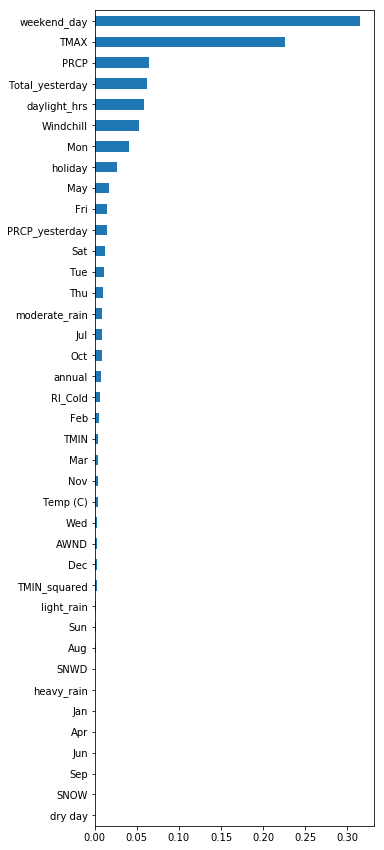

In [100]:
n = len(X_train.columns)
figsize = (5,15)

# Find important splits - put into a Series
importances = pd.Series(best.feature_importances_, X_train.columns)

# Save top features starting from the bottom to top
top_n = importances.sort_values()[-n:]

# Plot
plt.figure(figsize=figsize)
top_n.plot.barh()

## Drop-Column Importance

- Compare two models, one with the feature and one without the feature.
- Find the difference of the feature's MAE_with - MAE_without
- If the difference is big then it is important and small if unimportant

#Permutation Importance

### Do-It-By-Hand

In [111]:
# Test which feature we should permute, shuffle values
feature = 'weekend_day'

def permute(feature):

  # Copy and save
  X_test_permute = X_test.copy()

  # Permute the feature with np
  X_test_permute[feature] = np.random.permutation(X_test_permute[feature])

  # Predict
  y_pred_permute = best.predict(X_test_permute)

  # Compare original and permute to see if there's a differnece in MAE
  print('Feature tested for:',feature)
  print('Test MAE with original:', mean_absolute_error(y_test, y_pred))
  print('R2-score with original:', r2_score(y_test, y_pred))
  print('Test MAE with permute:', mean_absolute_error(y_test, y_pred_permute))
  print('R2-score with permute:', r2_score(y_test, y_pred_permute))
  
permute(feature)
# MAE close to original means unimportant and MAE far from original is important

Feature tested for: weekend_day
Test MAE with original: 239.95275268554687
R2-score with original: 0.9206407798609488
Test MAE with permute: 833.0865856933593
R2-score with permute: -0.07972752083185108


In [112]:
# Test another feature

feature = 'TMIN'

permute(feature)

Feature tested for: TMIN
Test MAE with original: 239.95275268554687
R2-score with original: 0.9206407798609488
Test MAE with permute: 255.50465576171874
R2-score with permute: 0.9104928331790801


#Eli5 library

In [114]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='neg_mean_absolute_error', cv='prefit',
                                 n_iter=100, random_state=42)

permuter.fit(X_test, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=130, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
           n_iter=100, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [115]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
598.9915 ± 116.6670,weekend_day
88.5794 ± 28.8586,PRCP
67.9641 ± 28.6486,TMAX
60.3335 ± 25.1331,Total_yesterday
43.7843 ± 18.9355,Fri
32.4631 ± 14.1985,holiday
31.3453 ± 13.7523,Tue
14.8311 ± 10.6363,Sat
12.6622 ± 6.3802,Mon
12.1967 ± 10.6876,TMIN


##Use importance for feature selection

In [0]:
# Finds all features greater than 0
mask = permuter.feature_importances_ > 0

# Save the feature names of important features
features = X_train.columns[mask]

# Save to training data
X_train = X_train[features]

In [120]:
#Refit the model after we remove features with zero importances

param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2,4)
}

# RSCV
search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions=param_distributions,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=10,
    cv=5,
    return_train_score=True,
    random_state=42
)

# Fit
search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f074d4f6a90>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f074d4f60b8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [121]:
print('Cross Validation MAE:', int(-search.best_score_))

Cross Validation MAE: 287


In [122]:
# TEST

# Save the best
best = search.best_estimator_

# Use Important features for test
X_test = X_test[features]

y_pred = best.predict(X_test)
print('Test MAE with Important features:', mean_absolute_error(y_test, y_pred))
print('Test R2 with Important features:', r2_score(y_test, y_pred))

Test MAE with Important features: 237.03818115234375
Test R2 with Important features: 0.9274375278120046


#Partial Dependence Plots(PDP)

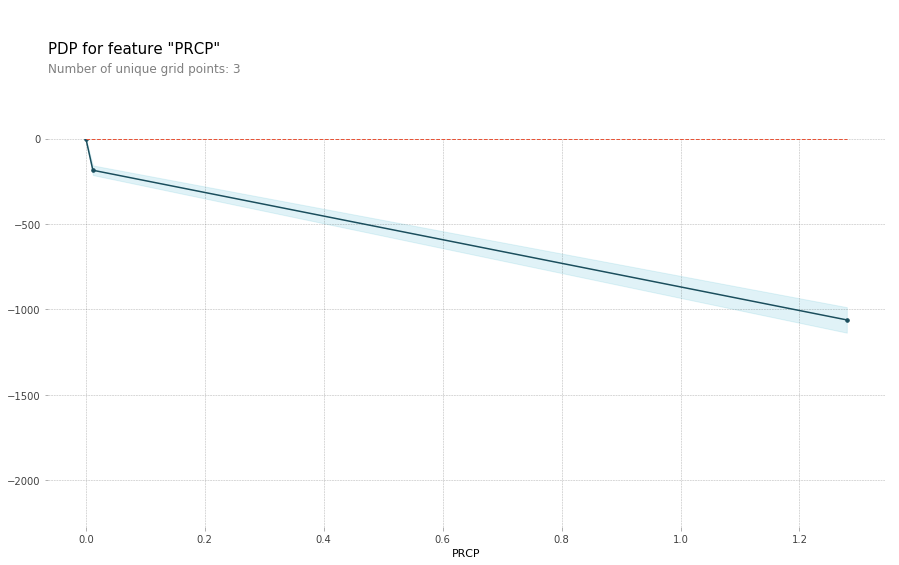

In [124]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'PRCP'

isolated = pdp_isolate(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

##PDP Plot with 2 features

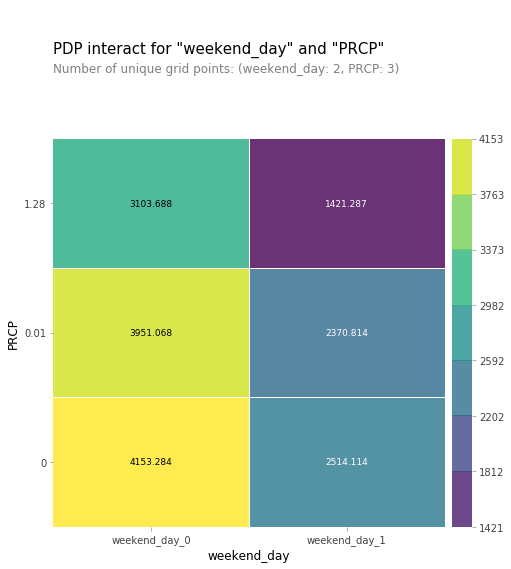

In [125]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['weekend_day', 'PRCP']

interaction = pdp_interact(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

#Shap Values - Indivdiual Predictions

In [130]:
# Choose a row to test
data_for_prediction = X_test.sample()
data_for_prediction

,PRCP,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Fri,Sat,holiday,daylight_hrs,Temp (C),annual,PRCP_yesterday,Windchill,Rl_Cold,May,moderate_rain,weekend_day
2015-07-09,0.0,28.9,14.4,34,4761.0,0.0,0.0,0.0,0.0,0.0,0.0,15.590387,21.65,0.123288,0.0,32.2684,3.723111,0.0,False,False


In [132]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)